# Importing packages

In [25]:
import pandas as pd
import numpy as np
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import exch
from sqlalchemy import inspect
import seaborn as sns
import matplotlib.pyplot as plt

# Getting the dataset using pandas library

In [27]:
data_from_csv = pd.read_csv("Baton_Rouge_Crime_Incidents.csv")

In [28]:
data_from_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83353 entries, 0 to 83352
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   INCIDENT NUMBER            83353 non-null  object 
 1   CHARGE ID                  83353 non-null  object 
 2   CHARGE DATE                83353 non-null  object 
 3   REPORT DATE                83353 non-null  object 
 4   APPROVED DATE              83353 non-null  object 
 5   ATTEMPTED OR COMMITTED     83353 non-null  object 
 6   STREET ADDRESS             72422 non-null  object 
 7   SUBADDRESS                 2349 non-null   object 
 8   CITY                       82180 non-null  object 
 9   STATE                      82221 non-null  object 
 10  ZIP CODE                   81737 non-null  float64
 11  DISTRICT                   81983 non-null  float64
 12  ZONE                       81983 non-null  object 
 13  SUBZONE                    81889 non-null  obj

# Finding missing values

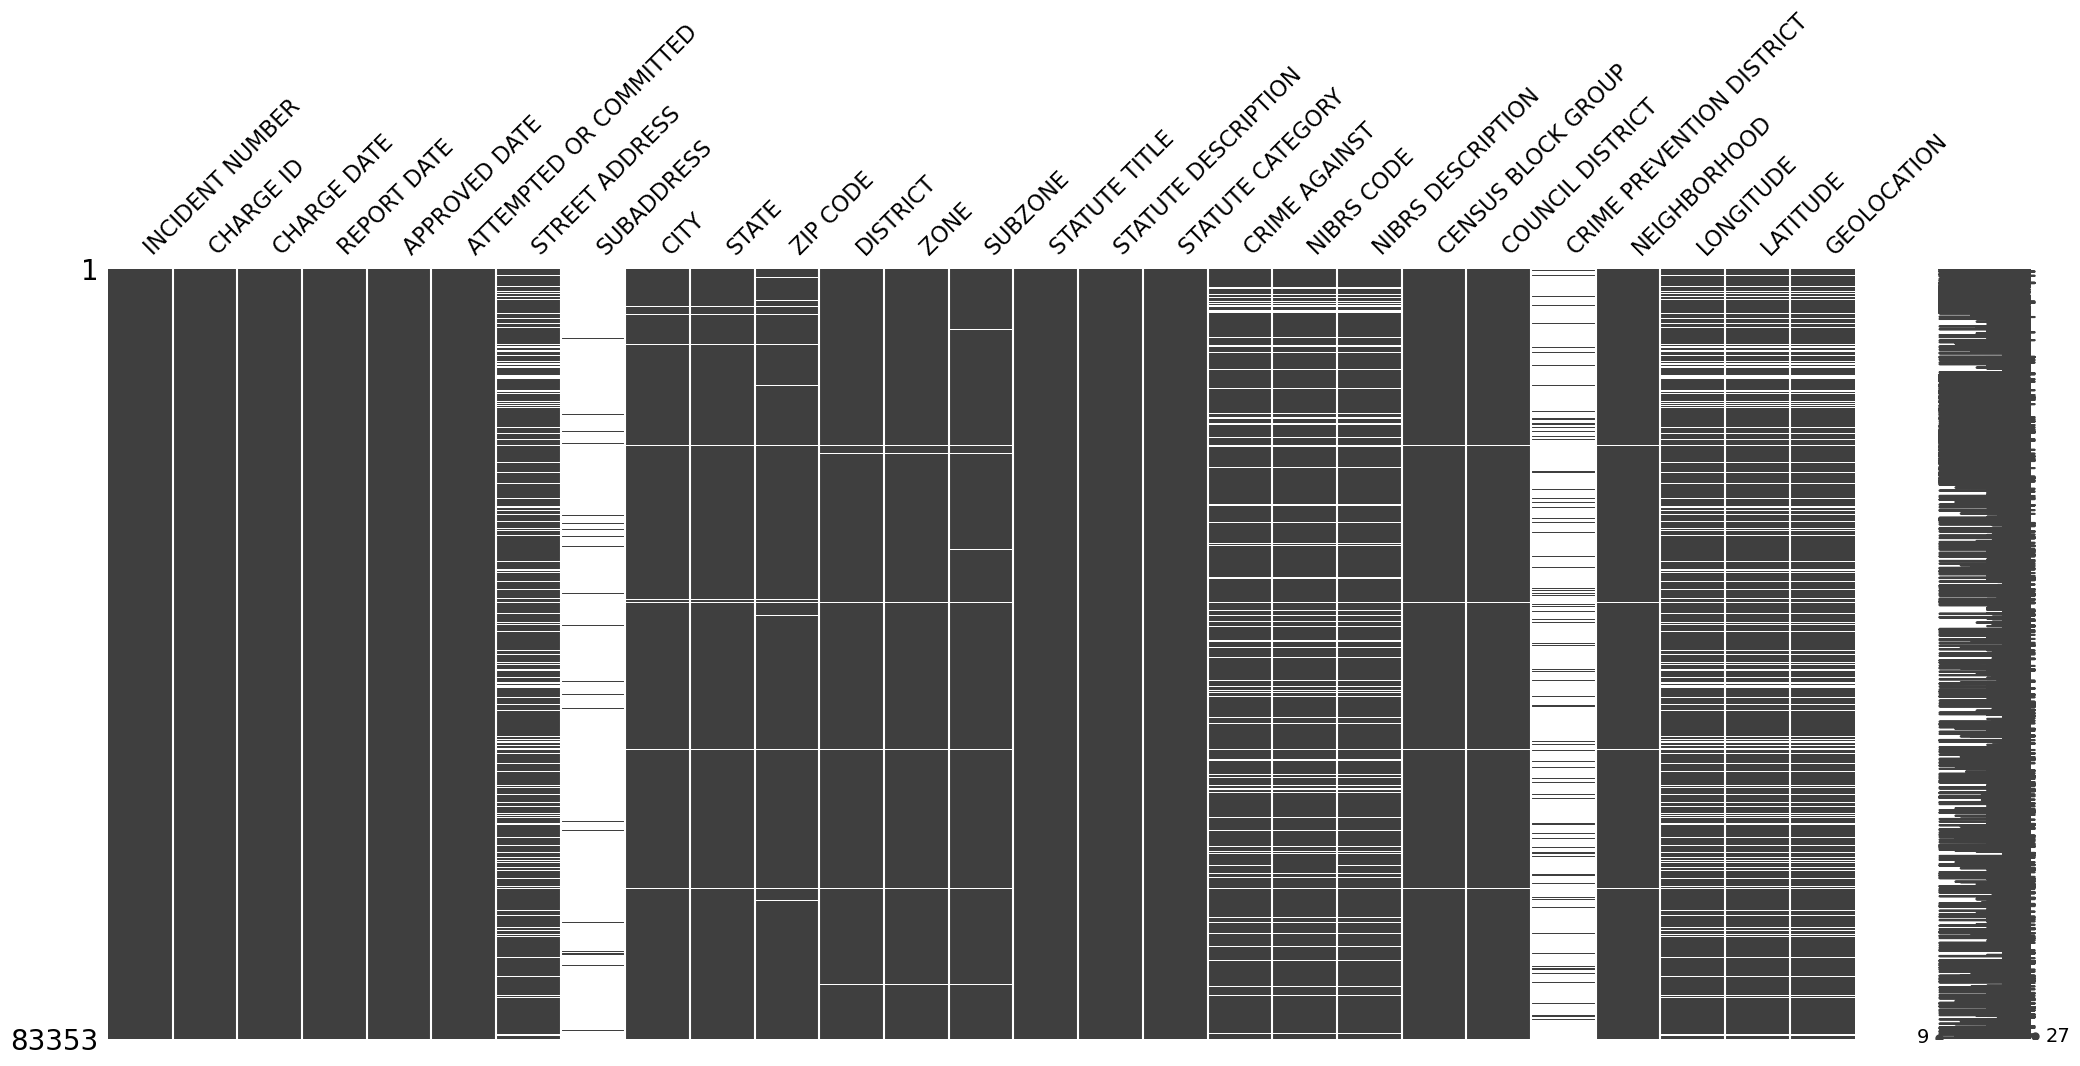

In [80]:
import missingno as msno

msno.matrix(data_from_csv)
plt.show()

In [73]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent
missing_percent = get_numerical_summary(data_from_csv)

STREET ADDRESS : 10931 (13.114%)
SUBADDRESS : 81004 (97.182%)
CITY : 1173 (1.407%)
STATE : 1132 (1.358%)
ZIP CODE : 1616 (1.939%)
DISTRICT : 1370 (1.644%)
ZONE : 1370 (1.644%)
SUBZONE : 1464 (1.756%)
CRIME AGAINST : 9557 (11.466%)
NIBRS CODE : 9499 (11.396%)
NIBRS DESCRIPTION : 9557 (11.466%)
CENSUS BLOCK GROUP : 1089 (1.306%)
COUNCIL DISTRICT : 1072 (1.286%)
CRIME PREVENTION DISTRICT : 73879 (88.634%)
NEIGHBORHOOD : 1072 (1.286%)
LONGITUDE : 11072 (13.283%)
LATITUDE : 11072 (13.283%)
GEOLOCATION : 11072 (13.283%)


# Cleaning - Deleting unwanted columns, dropping missing values, renaming some columns

In [72]:
# Drop the unwanted columns
data_from_csv_preprocessed = data_from_csv.drop(['CITY','STATUTE TITLE','CHARGE DATE','REPORT DATE','APPROVED DATE','INCIDENT NUMBER', 'CHARGE ID', 'REPORT DATE', 'APPROVED DATE', 'SUBADDRESS', 'STATE', 'ZIP CODE', 'DISTRICT', 'ZONE', 'CENSUS BLOCK GROUP', 'COUNCIL DISTRICT', 'CRIME PREVENTION DISTRICT', 'LONGITUDE', 'LATITUDE', 'GEOLOCATION'], axis=1)

new_column_names = {'ATTEMPTED OR COMMITTED':'attempted_or_committed','STREET ADDRESS':'street_address','SUBZONE':'subzone','STATUTE DESCRIPTION':'description','STATUTE CATEGORY':'categoty','CRIME AGAINST':'crime_against','NIBRS DESCRIPTION': 'offense','NIBRS CODE': 'offense_code','NEIGHBORHOOD':'neighborhood'}
data_from_csv_preprocessed.rename(columns=new_column_names, inplace=True)

# Print the number of remaining rows
print("Number of columns after dropping unwanted columns:", data_from_csv_preprocessed.shape[1])



Number of columns after dropping unwanted columns: 9


In [71]:
# Threshold to remove samples having missing values greater than threshold
THRESHOLD = 2

# Calculate missing count of each sample
print("Number of rows before dropping missing values:", len(data_from_csv_preprocessed))
for i in range(data_from_csv_preprocessed.shape[0]):
    data_from_csv_preprocessed.loc[i, 'missing_count'] = data_from_csv_preprocessed.iloc[i, :].isnull().sum()

# Assign the new DataFrame with the 'missing_count' column to a new variable or overwrite the original DataFrame
data_from_csv_preprocessed_with_missing_count = data_from_csv_preprocessed

# Drop samples with missing values greater than threshold
data_from_csv_preprocessed_filtered = data_from_csv_preprocessed_with_missing_count[data_from_csv_preprocessed_with_missing_count['missing_count'] <= THRESHOLD]

print("Number of rows after dropping samples with missing values greater than threshold:", len(data_from_csv_preprocessed_filtered))


Number of rows before dropping missing values: 83353
Number of rows after dropping samples with missing values greater than threshold: 73779


In [62]:
print("Missing values distribution: ")
print(df.isnull().mean())
print("")

Missing values distribution: 
attempted_or_committed    0.0
street_address            0.0
subzone                   0.0
description               0.0
categoty                  0.0
crime_against             0.0
offense_code              0.0
offense                   0.0
neighborhood              0.0
dtype: float64



# Transforming the cleaned dataframe to csv 

In [64]:
df.to_csv('cleaned_2.csv',index=False)
cleaned_data_df = pd.read_csv("cleaned_2.csv")
cleaned_data_df.head()

,attempted_or_committed,street_address,subzone,description,categoty,crime_against,offense_code,offense,neighborhood
0,COMMITTED,2414 DESOTO DR,4B3,UNAUTHORIZED USE OF A MOTOR VEHICLE,THEFT,PROPERTY,240,MOTOR VEHICLE THEFT,BAKER
1,COMMITTED,7801 SCENIC HWY,4C1,BATTERY OF A DATING PARTNER,BATTERY,PERSON,13B,SIMPLE ASSAULT,SCOTLANDVILLE
2,COMMITTED,4527 PERKINS RD,2B2,THEFT OF A MOTOR VEHICLE.,THEFT,PROPERTY,240,MOTOR VEHICLE THEFT,POLLARD / WOODCHASE
3,COMMITTED,1000 N 31ST ST,1B1,AGGRAVATED BATTERY,BATTERY,PERSON,13A,AGGRAVATED ASSAULT,FAIRFIELDS
4,COMMITTED,4570 EVANGELINE ST,4G2,SIMPLE CRIMINAL DAMAGE TO PROPERTY,CRIMINAL DAMAGE TO PROPERTY,PROPERTY,290,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,DELMONT PLACE


# Establishing postgres connection

In [66]:
# Define your database connection details.
dbname = "dap_project"
user = "postgres"
password = "postgres"
host = "localhost"

# Connect to the database.
conn = psycopg2.connect(database=dbname,
                        user=user,
                        password=password,
                        host=host)

print("connection successfull")

connection successfull


# Creating the table in postgres 

In [68]:
try:
    cur = conn.cursor() # Create a cursor object for executing SQL queries.
    # SQL query to create the table with column names and data types.
    cur.execute('''
        CREATE TABLE IF NOT EXISTS baton_rouge_crime_2(
            attempted_or_committed TEXT,
            street_address TEXT,
            subzone TEXT,
            description TEXT,
            categoty TEXT,
            crime_against TEXT,
            offense_Code TEXT,
            offense TEXT,
            neighborhood TEXT
        );
    ''')
    conn.commit() # Commit the transaction.
    print("Table created successfully!")
except psycopg2.Error as e:
    print("Error creating table:", e)
    conn.rollback() # Rollback the transaction in case of an error.
finally:
    cur.close() # Close the cursor.

Table created successfully!


# Inserting the data from the cleaned dataframe to postgres

In [70]:
try:
    engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{dbname}')
    inspector = inspect(engine)
    # Check if the table already contains data, if so, delete all the rows. 
    table_name = 'baton_rouge_crime_2'
    if table_name in inspector.get_table_names():
        with conn.cursor() as cursor:
            cursor.execute(f"DELETE FROM baton_rouge_crime_2")
            conn.commit()  # Commit the DELETE statement
            #print(f"All rows deleted from table '{table_name}'.")
    cleaned_data_df.to_sql('baton_rouge_crime_2', engine, if_exists='append', index=False)
    engine.dispose() # Dispose the engine after data is loaded.
    print("Data loaded to PostgreSQL successfully!")
except exc.SQLAlchemyError as e:
    print("Error loading data to PostgreSQL:", e)

Data loaded to PostgreSQL successfully!
